We will make a simple protein secondary structure predictor for predicting one of the three classes: coil, helix and beta sheet. Whereas popular tools like [psipred](http://bioinf.cs.ucl.ac.uk/psipred/) use neural networks on a window of amino acids, we will instead use a fully convolutional neural network to input the whole sequence. 
<brb>
Thus, the input will be sequences encoded as $N*C*L$ where $C$ = 20 (number of amino acids), $L$ = length and $N$ is the size of the minibatch, and the output will have the same dimensions except only three channels, corresponding to one of the three classes. Basically, we'll be doing image segmentation on the protein sequences.
<br>
<br> 
we will evaluate the quality of the predictions with the Q3 accuracy (basically accuracy across all residues) and the segment of overlap score. The segment of overlap score takes into account how much entire segments with the same secondary structure type overlap between the reference and the prediction, as opposed to the identity of individual amino acids. 
<br>In order to have an idea of how well we're doing, we will compare our results with the results obtained with psipred, although ideally we're not supposed to use single sequences for psipred, but a multiple sequence alignment.
<br>
<br> For training, validation and testing, we will use the data that was used to train the [jpred method](http://www.compbio.dundee.ac.uk/jpred4/about_RETR_JNetv231_details.shtml) as it is easily available and fulfills criteria such as a lack of structural/sequence homology between training and test set, which would lead to a biased evaluation.

In [64]:
import numpy as np
import itertools
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [65]:
train_ids = np.loadtxt('train_names', dtype='str')
test_ids = np.loadtxt('test_names', dtype='str')

In [66]:
training_items={}
for i in train_ids:
    with open('data/training/'+i+".fasta") as input:
        seq = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                seq += line.strip()
    with open('data/training/'+i+".dssp") as input:
        ss = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                ss += line.strip()
            
    training_items[i] = {'seq':seq, 'ss':ss}
    
    
test_items={}
for i in test_ids:
    with open('data/blind/'+i+".fasta") as input:
        seq = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                seq += line.strip()
    with open('data/blind/'+i+".dssp") as input:
        ss = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                ss += line.strip()
            
    test_items[i] = {'seq':seq, 'ss':ss}

In [67]:
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

pos_aa_dict = {j:i for i,j in aa_id_dict.items()}

ss_id_dict = {'H':0, 'E':1, '-':2}

pos_ss_dict = {j:i for i,j in ss_id_dict.items()}

def aa_to_onehot(aa_str, aa_to_nr=aa_id_dict, mask=None):
    """
    Onehot encode an amino acid string using a letter to number dictionary.
    The mask (from proteinnet files) is used to remove residues missing atoms from the primary sequence.
    """
    if mask!=None:
        mask_ind = np.asarray([x=='+' for x in mask])*1
        mask_ind = np.nonzero(mask_ind)
        aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # the mask indices are a list in a list
    init_array = np.zeros( (len(aa_to_nr.keys()), len(aa_str)) )
    for i,j in enumerate(aa_str):
        init_array[aa_to_nr[j], i] = 1
    return init_array

def label_to_index(ss, id_dict):
    labels = np.array([id_dict[i] for i in ss])
    return(labels)

def onehot_to_str(onehot_arr, map_dict=pos_aa_dict):
    '''Helper function to recover aa sequence from onehot encoding
        input must be aa*N numpy array'''
    aas = []
    N = onehot_arr.shape[1]
    for i in range(N):
        pos = np.where(onehot_arr[:, i]>0)[0]
        aas.append(map_dict[int(pos)])
    return "".join(aas)

def filter_proteins(prot_id, seq, allowed_symbols):
    allowed = True
    for i in seq:
        if i not in allowed_symbols:
            allowed = False
    return allowed
        

In [68]:
train_inds_filt = np.array([filter_proteins(i, training_items[i]['seq'], aa_id_dict.keys()) for i in train_ids])
test_inds_filt = np.array([filter_proteins(i, test_items[i]['seq'], aa_id_dict.keys()) for i in test_ids])

train_ids_filt = train_ids[train_inds_filt]
test_ids_filt = test_ids[test_inds_filt]

In [69]:
train_ids_filt.shape

(1345,)

In [70]:
for i in train_ids_filt:
    training_items[i]['seq_1h'] = aa_to_onehot(training_items[i]['seq'], aa_id_dict)[np.newaxis, :, :]
    training_items[i]['ss_idx'] = label_to_index(training_items[i]['ss'], ss_id_dict)[np.newaxis, :]
    
for i in test_ids_filt:
    test_items[i]['seq_1h'] = aa_to_onehot(test_items[i]['seq'], aa_id_dict)[np.newaxis, :, :]
    test_items[i]['ss_idx'] = label_to_index(test_items[i]['ss'], ss_id_dict)[np.newaxis, :]

In [71]:
np.random.seed(678)
inds_perm = np.random.permutation(len(train_ids_filt))
val_prots = train_ids_filt[inds_perm[0:int(np.floor(len(inds_perm)*0.2))]]
train_prots = train_ids_filt[inds_perm[int(np.floor(len(inds_perm)*0.2)):]]

In [72]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, ss):
        self.sequences = seqs
        self.ss = ss

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.ss[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    ss = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        ss_padded = np.pad(ss[i], ((0,0 ), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded).float()
        ss[i] = torch.tensor(ss_padded)
    seq_tensor = torch.cat(seqs, 0)
    ss_tensor = torch.cat(ss, 0)
    return [seq_tensor, ss_tensor]

def protein_collate2(batch):
    seqs = [item[0] for item in batch]
    ss = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        ss_padded = np.pad(ss[i], ((0,0 ), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded).float()
        ss[i] = torch.tensor(ss_padded).float()
    seq_tensor = torch.cat(seqs, 0)
    ss_tensor = torch.cat(ss, 0)
    return [seq_tensor, ss_tensor]

In [73]:
train_seqs = [training_items[i]['seq_1h'] for i in train_prots]
train_ss = [training_items[i]['ss_idx'] for i in train_prots]

val_seqs = [training_items[i]['seq_1h'] for i in val_prots]
val_ss = [training_items[i]['ss_idx'] for i in val_prots]

In [74]:
train_dataset = proteindataset(train_seqs, train_ss)
val_dataset = proteindataset(val_seqs, val_ss)
test_dataset = proteindataset([test_items[i]['seq_1h'] for i in test_items.keys()], [test_items[i]['ss_idx'] for i in test_items.keys()])

In [75]:
train_ss[0].shape

(1, 89)

In [76]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                         shuffle=False, num_workers=4, collate_fn=protein_collate)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                         shuffle=False, num_workers=4, collate_fn=protein_collate)

In [77]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

kd2 = 3
pad2 = int((kd2-1)/2)
kd3 = 5
pad3 = int((kd3-1)/2)
kd4 = 7
pad4 = int((kd4-1)/2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool1d(2)
        
        self.conv0 = nn.Conv1d(20, 32, kernel_size=1)
        self.conv0_bn = torch.nn.BatchNorm1d(32)
        self.conv1 = nn.Conv1d(32, 32, kernel_size=kd2, padding=pad2) # down
        self.conv1_bn = torch.nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=kd3, padding=pad3) # down 
        self.conv2_bn = torch.nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=kd4, padding=pad4) # down
        self.conv3_bn = torch.nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv4_bn = torch.nn.BatchNorm1d(128)
        
        self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=kd4, padding=pad4) # up
        self.deconv1_bn = torch.nn.BatchNorm1d(64)
        self.conv5 = nn.Conv1d(64, 64, 1)
        self.conv5_bn = torch.nn.BatchNorm1d(64)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=kd3, padding=pad3) # up
        self.deconv2_bn = torch.nn.BatchNorm1d(64)
        self.conv6 = nn.Conv1d(64, 64, 1)
        self.conv6_bn = torch.nn.BatchNorm1d(64)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=96, out_channels=32, kernel_size=kd2, padding=pad2) # up
        self.deconv3_bn = torch.nn.BatchNorm1d(32)
        self.conv7 = nn.Conv1d(32, 16, (1))
        self.conv7_bn = torch.nn.BatchNorm1d(16)
        self.conv8 = nn.Conv1d(16, 3, 1)
        self.conv8_bn = torch.nn.BatchNorm1d(3)
        self.conv9 = nn.Conv1d(3, 3, 1)

    def forward(self, x):
        conv0_out = F.relu(self.conv0_bn(self.conv0(x)))
        conv1_out = F.relu(self.conv1_bn(self.conv1(conv0_out)))
        conv2_out = F.relu(self.conv2_bn(self.conv2(conv1_out)))
        conv3_out = F.relu(self.conv3_bn(self.conv3(conv2_out)))
        conv4_out = F.relu(self.conv4_bn(self.conv4(conv3_out)))

        deconv1_out = F.relu(self.deconv1_bn(self.deconv1(conv4_out)))
        conv5_out = F.relu(self.conv5_bn(self.conv5(deconv1_out)))
        
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)  
        deconv2_out = F.relu(self.deconv2_bn(self.deconv2(deconv2_input)))
        conv6_out = F.relu(self.conv6_bn(self.conv6(deconv2_out)))
        
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = F.relu(self.deconv3_bn(self.deconv3(deconv3_input)))
        conv7_out = F.relu(self.conv7_bn(self.conv7(deconv3_out)))
        conv8_out = F.relu(self.conv8(conv7_out))
        conv9_out = self.conv9(conv8_out)
        return conv9_out


Now we train the network. Since we output a matrix of one-hot encoded classes for each protein instead of a single scalar, we can no longer use the default cross-entropy loss provided by pytorch and must use the 'dice loss' instead.
<br>
Fortunately, other people [(e.g. this person)](https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py) have already implemented such loss functions and we can simply copy paste. 

In [78]:
net = Net()

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(net.parameters(), lr=1e-3)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

prints_per_epoch = 3

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None
patience_val = 5
patience_counter = patience_val

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data
        #print(sequence.shape, true_angles.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # adding to running loss, we will output this at every verbose_k
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:
            if patience_counter < 1:
                break
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for j in valloader:
                pred_k = net(j[0])
                loss_k = criterion(pred_k, j[1]).item()
                validation_loss += loss_k/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))

            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    patience_counter = patience_val
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'fcn_mle.pt')
                else:
                    patience_counter -= 1
            

            running_loss = 0.0
            

print('Finished Training')

epoch: 0, iteration: 88] training loss: 1.0252212172143915, validation_loss: 1.0301439864041637
epoch: 0, iteration: 177] training loss: 0.8106757107745396, validation_loss: 1.0093996821726121
new best validation loss, saving..
epoch: 0, iteration: 266] training loss: 0.6372557714414061, validation_loss: 0.9261904307900758
new best validation loss, saving..
epoch: 1, iteration: 88] training loss: 0.591760841983088, validation_loss: 0.8835781216621402
new best validation loss, saving..
epoch: 1, iteration: 177] training loss: 0.5725573542412747, validation_loss: 0.835026384286277
new best validation loss, saving..
epoch: 1, iteration: 266] training loss: 0.542045656214939, validation_loss: 0.8261121370756929
new best validation loss, saving..
epoch: 2, iteration: 88] training loss: 0.519281091315023, validation_loss: 0.8024451082302295
new best validation loss, saving..
epoch: 2, iteration: 177] training loss: 0.5077718355682459, validation_loss: 0.7675220797939376
new best validation l

Let's check the loss curve and also generate predictions for the validation set with the best parameters.

In [80]:
net = Net()
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/ss_pred/fcn_mle.pt'))

net.eval()

validation_preds = [np.apply_along_axis(np.argmax, 1, net(i[0]).detach().numpy()) for i in valloader]
validation_reals = val_ss

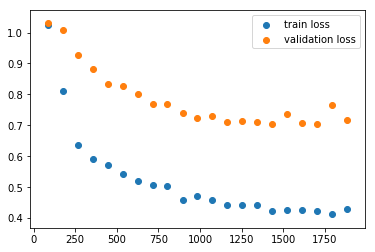

In [83]:
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

Now we evaluate the Q3 accuracy on the validation set.

In [84]:
def q3_acc(real, pred):
    if real.shape[0] == 1:
        real = np.squeeze(real, 0)
    if pred.shape[0] == 1:
        pred = np.squeeze(pred, 0)   
    return np.sum(real==pred)/real.shape[0]


def segment_of_overlap(ss_ref_str, ss_pred_str):
    ss_ref = get_segments(ss_ref_str)
    ss_pred = get_segments(ss_pred_str)
    val_total = 0
    N_total = 0
    for k in ss_ref.keys():
        subsum_k = 0
        N_k = 0
        for i in ss_ref[k]:
            l_s1 = len(i[1])
            N_k += l_s1
            for j in ss_pred[k]:
                l_s2 = len(j[1])
                minov = len(np.intersect1d(i[1], j[1]))
                if minov > 0:
                    maxov = len(np.union1d(i[1], j[1]))
                    delta = np.min([maxov-minov, minov, np.floor(l_s1/2), np.floor(l_s2/2)])
                    value = l_s1*(minov+delta)/maxov
                    subsum_k += value
        N_total += N_k
        val_total += subsum_k
    sov = val_total/N_total
    return sov

def get_segments(ss_str):
    ss_strs = ["".join(grp) for val, grp in itertools.groupby(ss_str)]
    idx_lens = []
    idx_start = 0
    for i in ss_strs:
        idx_lens.append(np.arange(idx_start, idx_start+len(i)))
        idx_start += len(i)
    segment_types = {'E':[], 'H':[], '-':[]}
    for i in range(len(ss_strs)):
        segment_types[ss_strs[i][0]].append([ss_strs[i], idx_lens[i]])
    return segment_types

def ints_to_symbols1d(ss_arr, map_dict=pos_ss_dict):
    if len(ss_arr.shape) > 1:
        for i,j in enumerate(ss_arr.shape):
            if j == 1:
                ss_arr = np.squeeze(ss_arr, i)
    return "".join([map_dict[i] for i in ss_arr])

In [97]:
val_accuracies = [q3_acc(i,j) for i,j in zip(validation_preds, validation_reals)]
print('FCN validation Q3 accuracy: ', np.mean(val_accuracies))

FCN validation Q3 accuracy:  0.6991616287529621


Since we're not really going to search for any hyperparameters, we can just evaluate the test set and also compare with psipred.

In [98]:
test_preds = [np.apply_along_axis(np.argmax, 1, net(i[0]).detach().numpy()) for i in testloader]
test_reals = [i[1].numpy() for i in testloader]

In [99]:
def parse_psipred(prot_id, letter_to_number=ss_id_dict):
    ss = ''
    with open('/Users/Deathvoodoo/big_folders_docs/ss_pred/ss_predictions_psipred/{}.horiz'.format(prot_id)) as input:
        lines = input.readlines()
        for line in lines:
            line = line.strip()
            line = line.split()
            if len(line)>0:
                if line[0] == 'Pred:' and len(line)>1:
                    ss += line[1]

    ss = ss.replace('C', '-') # hyphens should be equivalent to coils
    ss = np.array([letter_to_number[i] for i in ss])
    return ss
    

In [103]:
test_accuracies_fcn = [q3_acc(i,j) for i,j in zip(test_preds, test_reals)]


psipred_preds = [parse_psipred(i) for i in test_ids_filt]
psipred_acc = [q3_acc(i,j) for i,j in zip(psipred_preds, test_reals)]

print('FCN Q3 accuracy on test set: ',np.mean(test_accuracies_fcn))
print('psipred Q3 accuracy on test set: ',np.mean(psipred_acc))

FCN Q3 accuracy on test set:  0.703634580452644
psipred Q3 accuracy on test set:  0.7255188449781512


Let's check segment of overlap score.

In [101]:
test_preds_str_fcn = [ints_to_symbols1d(i) for i in test_preds]
test_preds_str_psipred = [ints_to_symbols1d(i) for i in psipred_preds]
test_reals_str = [ints_to_symbols1d(i) for i in test_reals] # same as grabbing strings directly from the dict

In [104]:
test_sovs_fcn = [segment_of_overlap(i, j) for i,j in zip(test_preds_str_fcn, test_reals_str)]
test_sovs_psipred = [segment_of_overlap(i, j) for i,j in zip(test_preds_str_psipred, test_reals_str)]

print('FCN SOV on test set: ', np.mean(test_sovs_fcn))
print('psipred SOV on test set: ', np.mean(test_sovs_psipred))


FCN SOV on test set:  0.7841545813866221
psipred SOV on test set:  0.7850154998573716
